# Abstract

(Just a sketch) Green's functions and their fourier transform are very useful entities, due to being directly measurable as physical quantities like the spectral function or the susceptibilty and being able to model complex many-body interactions using two-, three- and four-point functions. Due to these calculations being very costly, an intermediate representation of the Green's functions between matsubara frequency and time domain was developed. An advantage of this is a fast and efficient way to retrieve both function variants. This work compares several simpler approaches to geth the Fourier transform to the one using intermediate representations for two- and three-point functions. Afterwards, it is applied in a practical example.


# Introduction

The code for this work is written in Julia, using the library Fermions.jl. it models concepts for the second quantization like Fock-spaces, operators, solvers and much more for fermionic particles. First, four basic libraries are imported.

In [12]:
using Fermions
using LinearAlgebra
using Fermions.Aux
using Plots

## Hubbard model

The hubbard model (CITATION), while being a strongly simplified concept of modelling the atoms in a solid body as nodes and the electrons having the ability to hop between those nodes and punishing double-occupied states with energy costs, is still not always solvable but yields good results if aspects apart from locality are neglected.

In the current state, the function Hubbard() exists to connect the defined Fock-space with said parameters and connect them to create the hamiltonian H to represent a (in this case) two-site hubbard model. Note that the Fock-space is represented by four bits, encoding two sites with two different possibilities of spin.

In [13]:
# 2-site hubbard
space = FockSpace(4)
c = annihilators(space)
U = 3.
t = -1.0
μ = 1.5
H = Hubbard(space,U,t,μ)


Operator{Float64} for 4 flavours (10 terms):
-1.0 c[2]' c[4]
-1.0 c[1]' c[3]
-1.5 n[1]
-1.5 n[2]
3.0 n[1] n[2]
-1.5 n[3]
-1.5 n[4]
3.0 n[3] n[4]
-1.0 c[3]' c[1]
-1.0 c[4]' c[2]

## Green's Functions

We now want to compute the two-point or one-particle Green's function for this hubbard model. We define the temperature β and the operators A and B. Note that Fermions.jl also has functions for those existing; G_AB() and G_AB_Lehmann(). The former one being a computationally feasible method using time evolution using Krylov subspaces (CITATION), while the latter one uses the exact analytical expression. Both are computed in imaginary time. The naming convention of AB after the underline shows that the Green's function depends on the two operators A and B, which are in this case defined as creator and annihilator. The non-Lehmann function takes as input an additional parameter δ, which describes to quality of the approximation by limiting how many eigensatates are truncated.

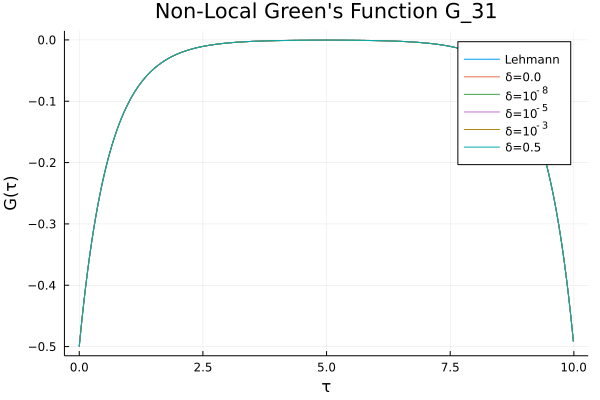

In [14]:
# We already have functions for Green: G_AB() & G_AB_Lehmann()
β = 10.
τ_arr = collect(0.:0.01:β-0.01)

A = Operator(space)
A += 1.0 * c[1]'
B = Operator(space)
B += 1.0 * c[1]

get_complex(x) = real(x)

G_31_Lehmann = real(G_AB_Lehmann(A,B,τ_arr,H,β))

G_31_00 = real(G_AB(A,B,τ_arr,H,β,space,0.0))
G_31_000000001 = real(G_AB(A,B,τ_arr,H,β,space,0.00000001))
G_31_000001 = real(G_AB(A,B,τ_arr,H,β,space,0.00001))
G_31_0001 = real(G_AB(A,B,τ_arr,H,β,space,0.001))
G_31_05 = real(G_AB(A,B,τ_arr,H,β,space,0.5))
plot(τ_arr,[G_31_Lehmann,G_31_00,G_31_000000001,G_31_000001,G_31_0001,G_31_05],
    title = "Non-Local Green's Function G_31", 
    label = ["Lehmann" "δ=0.0" "δ=10^{-8}" "δ=10^{-5}" "δ=10^{-3}" "δ=0.5"], 
    lw = 1, xlabel = "τ", ylabel = "G(τ)", fmt = :png)


Several different versions of the two-point Green's function are plotted here.

# Fourier transform of the two-point Green's function

Now, we want to look at different methods to retrieve the Green's function in frequency space. For this, we first define the number of Matsubara frequencies we want to look at, and compute them according to their definition. Note that for fermions, they are uneven multiples of π/β.

In [15]:
n_max = 50
n = collect(-n_max:1:n_max)
ω = (2n.+1)*π/β

101-element Vector{Float64}:
 -31.101767270538954
 -30.47344873982099
 -29.845130209103036
 -29.216811678385074
 -28.588493147667116
 -27.96017461694916
 -27.3318560862312
 -26.703537555513243
 -26.075219024795285
 -25.446900494077322
 -24.818581963359367
 -24.19026343264141
 -23.561944901923447
   ⋮
  24.818581963359367
  25.446900494077322
  26.075219024795285
  26.703537555513243
  27.3318560862312
  27.96017461694916
  28.588493147667116
  29.216811678385074
  29.845130209103036
  30.47344873982099
  31.101767270538954
  31.730085801256912

## Integral as a Sum

The first approach to get to the frequency domain is quite naive; the Fourier inteegral is approximated as a sum. For this, the imaginary time $\tau$ is spliced and inputted as an array, and then, the terms are summed up. This is done in the code via matrix multiplication.

Goal 1: Integral as a Sum

\begin{align}
    G(i \omega_n) \approx \sum_{j} e^{i \omega_n \tau_j} G(\tau_j) * \Delta \tau
\end{align}

In [16]:
# goal 1
function G_AB_transform(A, B, τ_arr, H, β, space, n_max)
    n = collect(-n_max:1:n_max)
    ω = (2n.+1)*π/β
    Δτ = (β/size(τ_arr)[1])
    
    matrix = ℯ.^(im*ω*τ_arr')
    return Δτ*matrix*G_AB(A,B,τ_arr,H,β,space,0.0)
end

G_AB_transform (generic function with 1 method)

An example imaginary time array is created in 0.01 steps and the imaginary part of the Green's function is plotted.

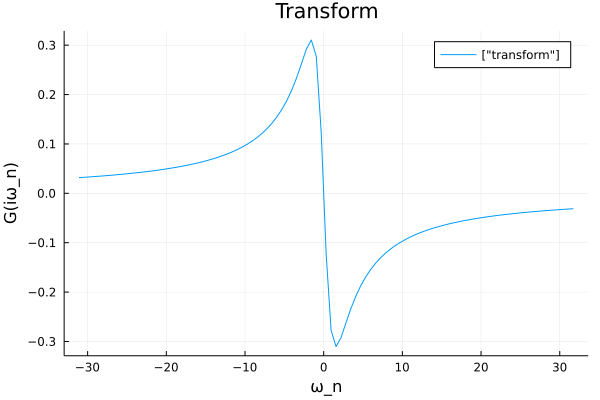

In [17]:
# make delta tau smaller!
τ_arr = collect(0.:0.01:β-0.01)


transform = imag(G_AB_transform(A, B, τ_arr, H, β, space, n_max))

plot(ω,transform,
    title = "Transform", 
    label = ["transform"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

In [18]:
#import Arpack
#ϵ, B = Arpack.eigs(H, nev=2, which=:SR)
#Array(saveH)

## Integration of the Lehmann representation

As a next step, we want to analytically Fourier-transform the Lehmann representation of the one-particle Green's function. (INSERT OUR CALCULATIONS HERE)
\begin{align}
G_{AB}(\tau) &= -\frac{1}{Z} \sum_n <n| e^{-(\beta - \tau) \epsilon_n} \hat A e^{-\tau \hat H} \hat B |n> = \\
&= -\frac{1}{Z} \sum_n e^{-\beta \epsilon_n} \sum_m e^{-\tau (\epsilon_m - \epsilon_n)} <n|A|m><m|B|n> = \\
&= -\frac{1}{Z} \sum_n G_{AB}^{(n)}(\tau) \\
&\textrm{with } G_{AB}^{(n)} = e^{-\beta \epsilon_n} \sum_m e^{-\tau (\epsilon_m - \epsilon_n)} <n|A|m><m|B|n>
\end{align}
In contrast to the G_AB() function, the Lehmann function uses all eigenstates and is exact, but needs much more computational time. In the low temperature limit both functions will yield the same result. Also for $\delta = 0$ both functions should yield the same results (but only for small Fock spaces, because some eigenvalues and -states will be truncated automatically - see LinearAlgebra.eigen() function in eigen.jl). The G_AB_Lehmann() function uses the internal G_AB_n_Lehmann() ($G_{AB}^{(n)}$) function for computing. Moreover, it also shifts the energy spectrum. This function also works for arbitrary fermionic or bosonic operators.



                                                

This is the code of Fermions.jl to compute the Lehmann representation.

In [19]:
function G_AB_n_Lehmann1(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,
    B::Operator,n::Array{Complex{T},1}, τ::Array{T,1},β::Real) where T <: Real
    val_arr = zeros(length(τ)) .+ 0im
    for i in 1:length(τ)
        for m in 1:length(ϵ)
            val_arr[i] += exp(-τ[i]*(ϵ[m]-ϵ_n)) * dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*n)
        end
        val_arr[i] *= exp(-β*ϵ_n)
    end
    return val_arr
end

function G_AB_Lehmann1(A::Operator, B::Operator, τ::Array{T,1},
    H::Operator,β::Real) where T <: Real
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    result = zeros(length(τ)) .+ 0im
    for i in 1:length(H_eigene)
        if i == 1
            result = G_AB_n_Lehmann1(H_eigvec,H_eigene,H_eigene[i],A,B,H_eigvec[:,i],τ,β)
        else
            result = result .+ G_AB_n_Lehmann1(H_eigvec,H_eigene,H_eigene[i],A,B,H_eigvec[:,i],τ,β)
        end
        Z += exp(-β*H_eigene[i]) #dot(n[:,i],n[:,i])*exp(-β*ϵ_n[i]) normed eigenvectors
    end
    result = -1.0 .* result ./ Z
    return result
end

G_AB_Lehmann1 (generic function with 1 method)

This is our adapted code to compute the Fourier-transformed Lehmann representation.

In [20]:
function G_AB_n_Lehmann_transform(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,
    B::Operator,n::Array{Complex{T},1}, ω::Array{T,1},β::Real) where T <: Real
    val_arr = zeros(length(ω)) .+ 0im
    for i in 1:length(ω)
        for m in 1:length(ϵ)
            val_arr[i] += (exp(-β*ϵ[m])+exp(-β*ϵ_n))/(ϵ[m]-ϵ_n-im*ω[i]) * dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*n)
        end
    end
    return val_arr
end

function G_AB_Lehmann_transform(A::Operator, B::Operator, τ::Array{T,1},
    H::Operator,β::Real, n_max) where T <: Real
    
    n = collect(-n_max:1:n_max)
    ω = (2n.+1)*π/β
    
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    result = zeros(length(τ)) .+ 0im
    for i in 1:length(H_eigene)
        if i == 1
            result = G_AB_n_Lehmann_transform(H_eigvec,H_eigene,H_eigene[i],A,B,H_eigvec[:,i],ω,β)
        else
            result = result .+ G_AB_n_Lehmann_transform(H_eigvec,H_eigene,H_eigene[i],A,B,H_eigvec[:,i],ω,β)
        end
        Z += exp(-β*H_eigene[i]) #dot(n[:,i],n[:,i])*exp(-β*ϵ_n[i]) normed eigenvectors
    end
    result = -1.0 .* result ./ Z
    return result
end

G_AB_Lehmann_transform (generic function with 1 method)

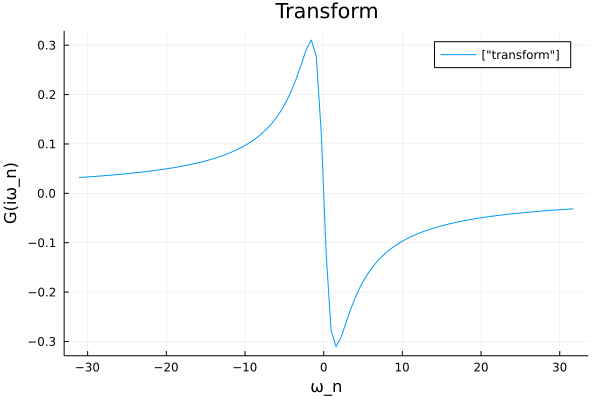

In [21]:
transform_Lehmann = imag(G_AB_Lehmann_transform(A, B, τ_arr, H, β, n_max))

plot(ω,transform_Lehmann,
    title = "Transform", 
    label = ["transform"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

This is the exact plot of the imaginary part of the transformed Lehmann function. 

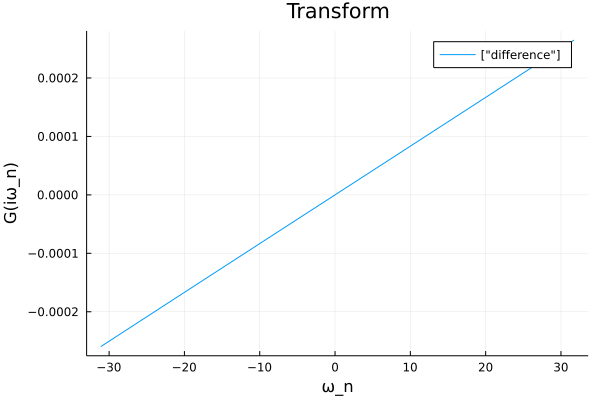

In [22]:
plot(ω,[transform-transform_Lehmann],
    title = "Transform", 
    label = ["difference"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

Note that the difference or error between the naive sum and the exact solution increases linearly.


## Weighted Integration via Gauss-Legendre

A smarter way to approximate the Fourier integral as a sum is the use of an additional weight factor of each sum term. (CITATION)

Goal 2: Integral with Gauss-Legendre

\begin{align}
    G(i \omega_n) \approx \sum_{j} \omega_j e^{i \omega_n \tau_j} G(\tau_j) \Delta \tau
\end{align}

In [23]:
using QuadGK

function G_AB_gl_part(A, B, H, β, space, ω_j)
    f(x)=(ℯ.^(im*ω_j*x)*(G_AB(A,B,[x],H,β,space,0.0)))
    return quadgk(f, 0, β, rtol=1e-2)
end

function G_AB_gl_transform(A, B, H, β, space, n_max)
    n = collect(-n_max:1:n_max)
    ω = (2n.+1)*π/β
    #Δτ = (β/size(τ_arr)[1])
    #matrix = ℯ.^(im*ω*τ_arr')
    #return Δτ*matrix*G_AB(A,B,τ_arr,H,β,space,0.0)
    result = []
    for ω_j in ω
        I, w = G_AB_gl_part(A, B, H, β, space, ω_j)
        append!(result,I)
    end
    return result
end

#integral, err = quadgk(x -> exp(-x^2), 0, 1, rtol=1e-8)


    

G_AB_gl_transform (generic function with 1 method)

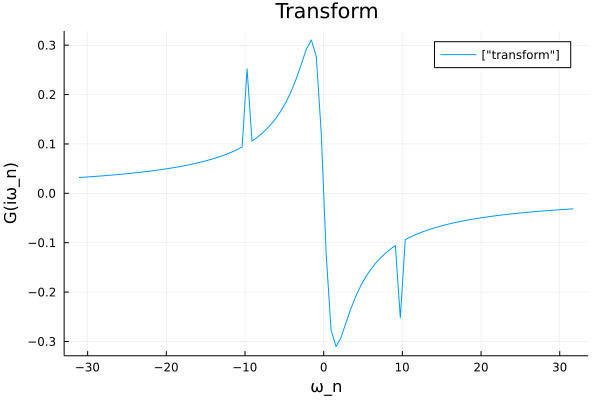

In [24]:

transform_gl = imag(G_AB_gl_transform(A, B, H, β, space, n_max))

plot(ω,transform_gl,
    title = "Transform", 
    label = ["transform"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

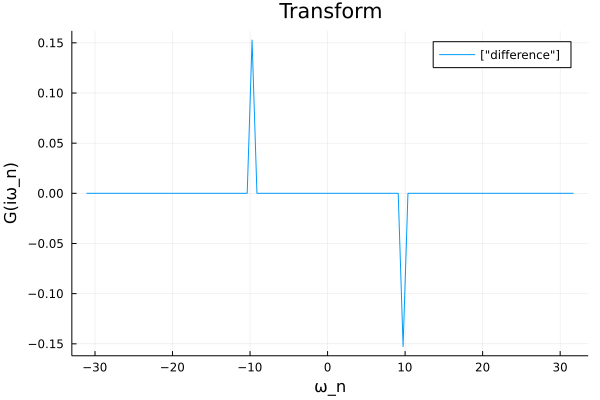

In [25]:
plot(ω,[transform_gl-transform_Lehmann],
    title = "Transform", 
    label = ["difference"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

In [26]:
using FastGaussQuadrature

#(b-a)/2*x)+(a+b)/2
#(b-a)/2*

function G_AB_gl2_part(A, B, H, β, space, ω_j)
    a = 0
    b = β
    x, w = gausslegendre(50)
    f(x)=(ℯ.^(im*ω_j*x)*(G_AB(A,B,[x],H,β,space,0.0)))
    g(x)=(b-a)/2*f(((b-a)/2*x)+(a+b)/2)
    return dot(w, g.(x))
end

function G_AB_gl2_transform(A, B, H, β, space, n_max)
    n = collect(-n_max:1:n_max)
    ω = (2n.+1)*π/β
    #Δτ = (β/size(τ_arr)[1])
    #matrix = ℯ.^(im*ω*τ_arr')
    #return Δτ*matrix*G_AB(A,B,τ_arr,H,β,space,0.0)
    result = []
    for ω_j in ω
        I = G_AB_gl2_part(A, B, H, β, space, ω_j)
        append!(result,I)
    end
    return result
end

#x, w = gausslegendre(3);
#x^4;
#I = dot(w, f.(x));


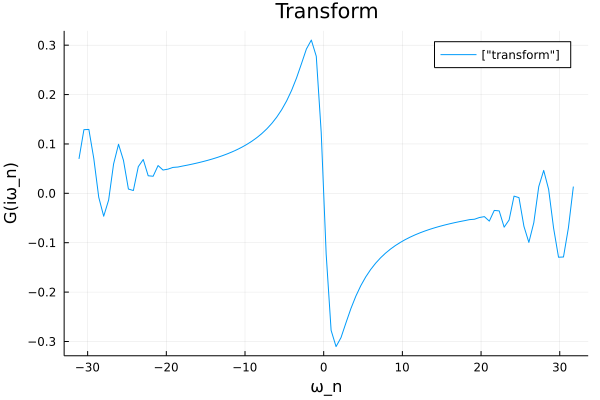

In [27]:

transform_gl2 = imag(G_AB_gl2_transform(A, B, H, β, space, n_max))

plot(ω,transform_gl2,
    title = "Transform", 
    label = ["transform"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

## Intermediate Representation

Now we come to intermediate representations. (CITATION)

Goal 3: IR

Before:

\begin{align}
    G(i \omega_n) \approx \sum_{j} \omega_j e^{i \omega_n \tau_j} G(\tau_j)
\end{align}

After:

\begin{align}
G(\tau_j) \text{ and } \hat{G}(\omega_n) \text{ share } g_e 
\end{align}

\begin{align}
g_l = \arg\min_{g} \sum_{j} | G(\tau_j) - \sum_{l} g_l U_l(\tau_j)  | ^2
\end{align}

something like lstsq(F,G), G is a vector, F a matrix






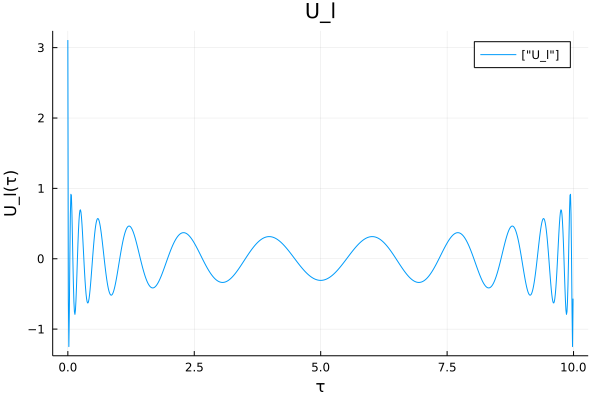

In [28]:
G = G_AB(A,B,τ_arr,H,β,space,0.0)

using SparseIR

function getOmega(n)
    return (2n.+1).*π./β
end

function getN(ω)
   return (ω.*β./π.-1)./2 
end

beta = 10
wmax = 20
eps = 1e-7

basis_f = FiniteTempBasis(fermion, beta, wmax, eps)
#basis_b = FiniteTempBasis(boson, beta, wmax, eps)
#basis = FiniteTempBasis("F", beta, wmax, eps=1e-10)
smplt = TauSampling(basis_f)
pointst = smplt.sampling_points
smplm = MatsubaraSampling(basis_f)
pointsm = smplm.sampling_points
plot(τ_arr[1:1000],basis_f.u[0](τ_arr[1:1000]),
    title = "U_l", 
    label = ["U_l"], 
    lw = 1, xlabel = "τ", ylabel = "U_l(τ)", fmt = :png)

In [29]:
#U = basis_f.u(τ_arr[1:1000])
pointsm

30-element Vector{Int64}:
 -321
 -305
 -129
  -75
  -49
  -35
  -25
  -19
  -13
  -11
   -9
   -7
   -5
    ⋮
    7
    9
   11
   13
   19
   25
   35
   49
   75
  129
  305
  321

In [30]:
#(basis_f)
#T = typeof(smpl)
#for (name, typ) in zip(fieldnames(T), T.types)
#    println("type of the fieldname $name is $typ")
#end

LoadError: UndefVarError: smpl not defined

In [31]:
#g = (1.0:24.0)# 24 g
#U'*g - G


U = basis_f.u(pointst)
#U = basis_f.u(τ_arr)
G = G_AB(A,B,pointst,H,β,space,0.0)
#G = G_AB(A,B,τ_arr,H,β,space,0.0)

28-element Vector{ComplexF64}:
   -0.49241898941285345 - 0.0im
    -0.4849668523313096 - 0.0im
   -0.45092542254936924 - 0.0im
      -0.40100716491196 - 0.0im
    -0.3395384151747234 - 0.0im
   -0.27170907499757396 - 0.0im
   -0.20313891402418954 - 0.0im
   -0.13945662811268192 - 0.0im
   -0.08576229765391259 - 0.0im
   -0.04573002407670299 - 0.0im
  -0.020371094181067157 - 0.0im
  -0.007353658169752049 - 0.0im
 -0.0021643461035775378 - 0.0im
                        ⋮
  -0.007353658169752042 - 0.0im
  -0.020371094181067143 - 0.0im
   -0.04573002407670293 - 0.0im
   -0.08576229765391248 - 0.0im
   -0.13945662811268175 - 0.0im
   -0.20313891402418938 - 0.0im
    -0.2717090749975736 - 0.0im
     -0.339538415174723 - 0.0im
    -0.4010071649119594 - 0.0im
    -0.4509254225493688 - 0.0im
   -0.48496685233130904 - 0.0im
   -0.49241898941285384 - 0.0im

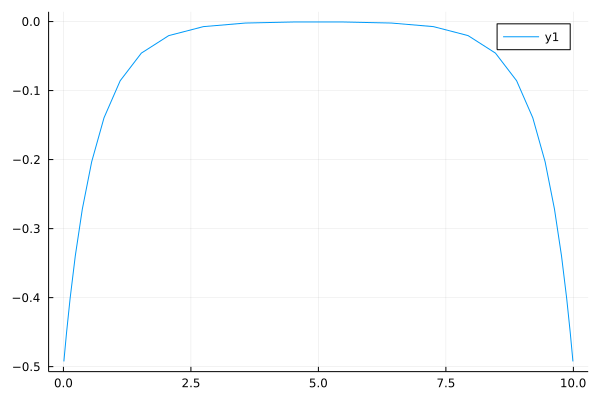

In [32]:
# using LsqFit too specific, G(t)-G(e)
#G = G_AB(A,B,τ_arr,H,β,space,0.0)

#model(t, g) = G_AB(A,B,t,H,β,space,0.0)' - g*basis_f.u(t)
# some example data
# xdata: independent variables
# ydata: dependent variable
#xdata = τ_arr
#ydata = model(xdata, [1.0 2.0]) + 0.1*randn(length(xdata))
#p0 = [0.5, 0.5]
#fit = curve_fit(model, xdata, ydata, p0)
#param = fit.param
#plot([xdata,xdata],[ydata, model(xdata,param)])




using IterativeSolvers
#minimize ∥Ax−b∥^2
#g=lsqr(U', G) #fit von SpareIR
g=U'\G
plot(pointst, real((g'*U)'))



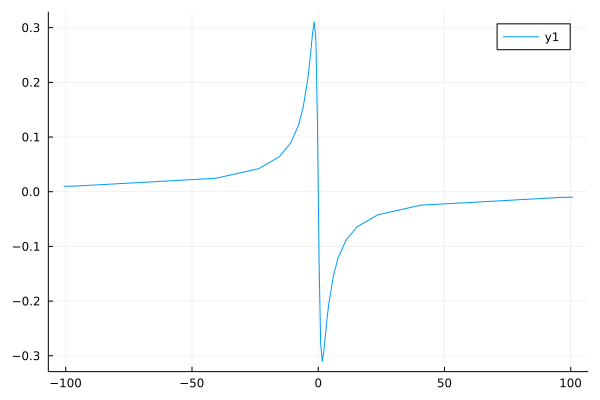

In [33]:
#2*n_max+1
#v = 2*collect(1:1:getN(wmax)).-1
#v = collect(-n_max:1:n_max)
v = 2n.+1 #important
Uhat = basis_f.uhat(pointsm)
#Uhat'*g
transform_IR = imag(transpose(Uhat)*g)
plot(pointsm.*π./β, transform_IR)
#ω
#pointsm[8:27]


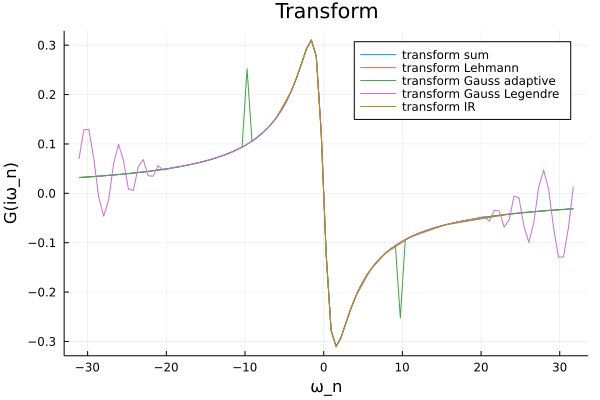

In [34]:
plot(ω,[transform, transform_Lehmann, transform_gl, transform_gl2],
    title = "Transform", 
    label = ["transform sum" "transform Lehmann" "transform Gauss adaptive" "transform Gauss Legendre"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)
plot!(pointsm[8:27].*π./β, transform_IR[8:27],
label = "transform IR")

In summary, this plot shows all of the five different ways to compute the Green's function. Note that the approximation for some of these functions are made so big that their error behaviour is clearly visible. (TIME EVALUATION?)

Here is my nifty citation {cite}`perez2011python`.

```{bibliography}
```